In [1]:
!pip install patchify

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from patchify import patchify
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping 

In [3]:
"""Hyperparameters"""
img_size = 200
num_channels = 3
patch_size = 25
num_patches = (img_size**2) // (patch_size**2)
flat_patches_shape = (num_patches, patch_size*patch_size*num_channels)

batch_size = 32
lr = 1e-4
num_epochs = 100
num_classes = 29
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 
               'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

if not os.path.exists('files'):
    os.makedirs('files')

PATH = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
model_path = os.path.join('files', 'model.h5')
log_path = os.path.join('files', 'log.csv')

In [6]:
images = shuffle(glob(os.path.join(PATH, '*', '*.jpg')))
split = int(len(images)*0.1)
train_x, valid_x = train_test_split(images, test_size=split, random_state=42)
train_x, test_x = train_test_split(train_x, test_size=split, random_state=42)
print(f"Total: {len(images)}, Train: {len(train_x)}, Validation: {len(valid_x)}, Test: {len(test_x)}")

Total: 87000, Train: 69600, Validation: 8700, Test: 8700


In [7]:
def process_img_label(path):
    """Reading Images"""
    path = path.decode()
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_size, img_size))
    img = img/255.0
    
    """Patches"""
    patch_shape = (patch_size, patch_size, num_channels)
    patches = patchify(img, patch_shape, patch_size)
    patches = np.reshape(patches, flat_patches_shape)
    patches = patches.astype(np.float32)
    
    """Labels"""
    class_name = path.split('/')[-2]
    class_idx = class_names.index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)
    return patches, class_idx

In [8]:
def parse(path):
    patches, labels = tf.numpy_function(process_img_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, num_classes)
    
    patches.set_shape(flat_patches_shape)
    labels.set_shape(num_classes)
    
    return patches, labels

In [9]:
def tf_dataset(images, batch=32):
    data = tf.data.Dataset.from_tensor_slices((images))
    data = data.map(parse).batch(batch).prefetch(8)
    return data

# ViT Model

In [10]:
"""Configurations"""
num_layers = 12
hidden_dim = 768
mlp_dim = 3072
num_heads = 12
dropout_rate = 0.1

In [11]:
class ClassToken(Layer):
    def __init__(self):
        super().__init__()
    
    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1,1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )
    
    def call(self, inputs):
        batch_size__ = tf.shape(inputs)[0]
        hidden_dim__ = self.w.shape[-1]
        
        cls = tf.broadcast_to(self.w, [batch_size__, 1, hidden_dim__])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

In [12]:
def mlp(x):
    x = Dense(mlp_dim, activation="gelu")(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(hidden_dim)(x)
    x = Dropout(dropout_rate)(x)
    return x

In [13]:
def transformer_encoder(x):
    skip1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=num_heads, key_dim=hidden_dim
    )(x, x)
    x = Add()([x, skip1])
    skip2 = x
    x = LayerNormalization()(x)
    x = mlp(x)
    x = Add()([x, skip2])
    
    return x

In [14]:
def ViT():
    """Input"""
    input_shape = (num_patches, patch_size*patch_size*num_channels)
    inputs = Input(input_shape)
    
    """Patch + Embeddings"""
    patch_embed = Dense(hidden_dim)(inputs)
    
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embed = Embedding(input_dim=num_patches, output_dim=hidden_dim)(positions)
    
    embed = patch_embed + pos_embed
    
    """Adding Class Token"""
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed])
    
    for _ in range(num_layers):
        x = transformer_encoder(x)
    
    """Classification Head"""
    x = LayerNormalization()(x)
    x = x[:, 0, :]
    
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, x)
    return model

In [15]:
strategy = tf.distribute.MirroredStrategy()

In [16]:
batch_size = batch_size * strategy.num_replicas_in_sync

In [17]:
train_data = tf_dataset(train_x, batch=batch_size)
valid_data = tf_dataset(valid_x, batch=batch_size)

In [18]:
with strategy.scope():
    model = ViT()
    model.compile(loss='categorical_crossentropy', 
             optimizer=tf.keras.optimizers.Adam(lr, clipvalue=1.0),
             metrics=['acc'])
# model.summary()

In [23]:
callbacks = [
    ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
    CSVLogger(log_path),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False),
]

model.fit(
    train_data,
    epochs=num_epochs,
    validation_data=valid_data,
    callbacks=callbacks
)

In [19]:
df = pd.read_csv('../input/modelvit/files/log.csv')
df # training log

,epoch,acc,loss,lr,val_acc,val_loss
0,0,0.126451,3.032644,0.0001,0.335287,1.996453
1,1,0.471537,1.543092,0.0001,0.588621,1.162308
2,2,0.685848,0.884915,0.0001,0.736782,0.687658
3,3,0.777687,0.617579,0.0001,0.805747,0.531542
4,4,0.835144,0.452614,0.0001,0.860345,0.380569
5,5,0.860661,0.384643,0.0001,0.867126,0.365728
6,6,0.886810,0.310404,0.0001,0.918621,0.223232


In [20]:
test_data = tf_dataset(test_x, batch=batch_size)

In [21]:
with strategy.scope():
    model = ViT()
    model.load_weights('../input/modelvit/files/model.h5')
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
             optimizer=tf.keras.optimizers.Adam(lr),
             metrics=['acc'])
    model.evaluate(test_data)

136/136 [==============================] - 111s 715ms/step - loss: 0.2306 - acc: 0.9185


In [ ]:
## Test accuracy 91.85%

In [24]:
predictions = model.predict(test_data)

In [25]:
predictions = np.argmax(predictions, axis=1)

In [27]:
predictions.shape

(8700,)

In [31]:
class_names[predictions[0]], test_x[0].split('/')[-2]

('W', 'W')

In [84]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt

In [59]:
y_true = []
y_pred = []
for i, p in enumerate(test_x):
    y = test_x[i]
    y_true.append(y.split('/')[-2])
for i, j in enumerate(predictions):
    y_pred.append(class_names[predictions[i]])

In [60]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           A       0.93      0.97      0.95       286
           B       0.98      0.92      0.95       288
           C       0.93      0.97      0.95       295
           D       0.97      0.89      0.93       296
           E       0.89      0.96      0.92       313
           F       0.97      0.91      0.94       310
           G       0.95      0.94      0.95       324
           H       0.95      0.94      0.94       261
           I       0.99      0.93      0.96       316
           J       0.95      0.97      0.96       311
           K       0.95      0.98      0.96       290
           L       0.94      0.98      0.96       279
           M       0.89      0.82      0.86       319
           N       0.79      0.96      0.87       281
           O       0.95      0.88      0.91       309
           P       0.96      0.98      0.97       315
           Q       0.98      0.95      0.96       292
           R       0.95    

In [61]:
cm = confusion_matrix(y_true, y_pred)

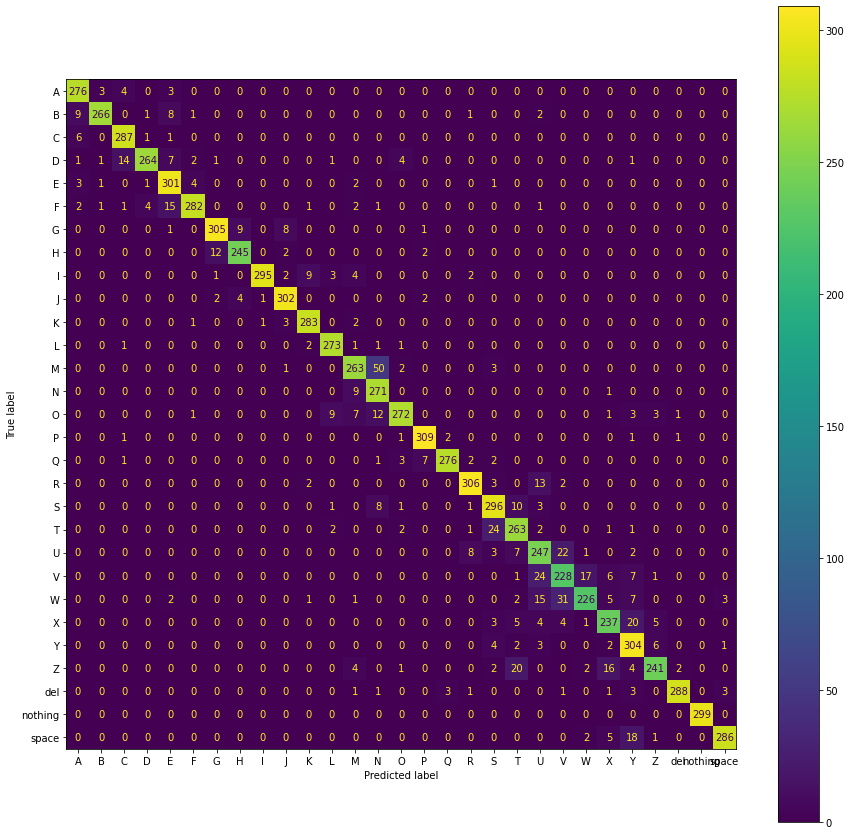

In [112]:
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)  
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
plt.show()